In [1]:
!cp -r drive/MyDrive/models models/
!cp -r drive/MyDrive/data data

In [2]:
%pip install basicsr facexlib realesrgan gfpgan segmentation-models-pytorch

In [3]:
import os
import cv2
import torch
import numpy as np
import matplotlib.pyplot as plt
import segmentation_models_pytorch as smp
from gfpgan import GFPGANer
from basicsr.archs.rrdbnet_arch import RRDBNet
from realesrgan import RealESRGANer

In [4]:
class RealESRGANEnhancer:
    def __init__(
        self,
        model_path: str = "models/RealESRGAN_x4plus.pth",
        scale: int = 4,
        tile: int = 256,
        device: str | None = None,
    ):
        """Wrapper around Real-ESRGAN super-resolution model."""
        self.device = torch.device(device if device else ("cuda" if torch.cuda.is_available() else "cpu"))
        self.scale = scale
        self.tile = tile
        self.model_path = model_path

        # Build model architecture
        self.model = RRDBNet(
            num_in_ch=3,
            num_out_ch=3,
            num_feat=64,
            num_block=23,
            num_grow_ch=32,
            scale=scale,
        )

        # Initialize enhancer
        self.enhancer = RealESRGANer(
            scale=scale,
            model=self.model,
            model_path=model_path,
            tile=tile,
            device=self.device,
            half=(self.device.type == "cuda"),
        )

    def enhance(self, img):
        """Run Real-ESRGAN super-resolution on an image (np.ndarray)."""
        if img is None:
            raise ValueError("Input image is None")
        output, _ = self.enhancer.enhance(img, outscale=self.scale)
        return output

In [5]:
class GFPGANEnhancer:
    def __init__(
        self,
        model_path: str = "models/GFPGANv1.3.pth",
        bg_model_path: str = "models/RealESRGAN_x4plus.pth",
        upscale: int = 4,
        tile: int = 256,
        device: str | None = None,
        bg_scale: int | None = None,
    ):
        """Wrapper around GFPGAN face restoration model with RealESRGAN background upsampler."""
        self.device = torch.device(device if device else ("cuda" if torch.cuda.is_available() else "cpu"))
        self.upscale = upscale
        self.tile = tile
        self.bg_scale = bg_scale if bg_scale is not None else upscale

        # Background upsampler using the existing RealESRGANEnhancer
        self.bg_upsampler = RealESRGANEnhancer(
            model_path=bg_model_path,
            scale=self.bg_scale,
            tile=tile,
            device=self.device.type,
        ).enhancer

        # GFPGAN restorer
        self.restorer = GFPGANer(
            model_path=model_path,
            upscale=upscale,
            arch="clean",
            channel_multiplier=2,
            bg_upsampler=self.bg_upsampler,
            device=self.device,
        )

    def enhance(self, img, has_aligned=False, only_center_face=False, paste_back=True):
        """Run GFPGAN restoration on an image (np.ndarray). Returns restored image only."""
        if img is None:
            raise ValueError("Input image is None")

        _, _, restored_img = self.restorer.enhance(
            img,
            has_aligned=has_aligned,
            only_center_face=only_center_face,
            paste_back=paste_back,
        )
        return restored_img

In [6]:
class Colorizer:
    def __init__(self, model_path, encoder="efficientnet-b2", device=None):
        self.device = torch.device(device if device else ("cuda" if torch.cuda.is_available() else "cpu"))

        # Initialize model structure
        self.model = smp.Unet(
            encoder_name=encoder,
            encoder_weights=None, # We load custom weights
            in_channels=3,  # Grayscale input (L channel)
            classes=2  # Output (ab channels)
        )

        # Load weights
        checkpoint = torch.load(model_path, map_location=self.device)
        self.model.load_state_dict(checkpoint)
        self.model.to(self.device)
        self.model.eval()


    def preprocess(self, img_rgb):
        # Convert to Lab
        img_lab = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2Lab)
        L = img_lab[:, :, 0]

        # Save the original dimensions
        original_h, original_w = L.shape

        # Resize the input image
        input_size = (224, 224)
        L_resized = cv2.resize(L, input_size)

        # Normalize
        L_norm = L_resized.astype(np.float32) / 255.0
        L_tensor = torch.from_numpy(L_norm).unsqueeze(0) # (1, H, W)

        # Repeat the single L channel to imitate a 3-channel input
        L_tensor = L_tensor.repeat(3, 1, 1) # (3, H, W)

        # Normalize (ImageNet stats)
        mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
        std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
        L_tensor = (L_tensor - mean) / std

        return L_tensor.unsqueeze(0).to(self.device), L, (original_h, original_w)


    def predict(self, img_rgb):
        """
        Input: RGB image (even if it's grayscale, read it as RGB)
        Output: Colorized RGB numpy image
        """
        tensor_input, L_original, (h, w) = self.preprocess(img_rgb)

        with torch.no_grad():
            ab_pred = self.model(tensor_input) * 1.05

        # Post-process
        ab_pred = ab_pred.cpu().squeeze(0).numpy().transpose(1, 2, 0)

        # Resize ab channels back to the original image size
        ab_pred = cv2.resize(ab_pred, (w, h))

        # Denormalize ab
        ab_pred = (ab_pred * 128.0 + 128.0).astype(np.uint8)

        # Combine with the original L channel
        lab_out = np.concatenate((L_original[:, :, np.newaxis], ab_pred), axis=2)
        rgb_out = cv2.cvtColor(lab_out, cv2.COLOR_Lab2RGB)

        return rgb_out

In [7]:
class ChronoVisionPipeline:
    def __init__(self,
        colorizer_weights,
        gfpgan_weights,
        esrgan_weights,
        device=None
    ):
        print("Initializing ChronoVision Pipeline...")

        # Stage 1: Colorization
        self.colorizer = Colorizer(
            model_path=colorizer_weights,
            device=device
        )

        # Stage 2 & 3: Restoration & Upscaling (GFPGAN wraps RealESRGAN)
        self.restorer = GFPGANEnhancer(
            model_path=gfpgan_weights,
            bg_model_path=esrgan_weights,
            upscale=4,
            device=device
        )


    def run(self, image_path):
        # 1. Load Image
        img = cv2.imread(image_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        # 2. Colorize
        print("Running Stage 1: Colorization...")
        colorized = self.colorizer.predict(img)

        # 3. Restore
        print("Running Stage 2: Face Restoration & Upscaling...")
        # GFPGAN expects RGB numpy array
        final_output = self.restorer.enhance(
            colorized,
            has_aligned=False,
            only_center_face=False,
            paste_back=True
        )

        return img, colorized, final_output

Initializing ChronoVision Pipeline...


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Downloading: "https://github.com/xinntao/facexlib/releases/download/v0.1.0/detection_Resnet50_Final.pth" to /content/gfpgan/weights/detection_Resnet50_Final.pth



100%|██████████| 104M/104M [00:00<00:00, 373MB/s] 


Downloading: "https://github.com/xinntao/facexlib/releases/download/v0.2.2/parsing_parsenet.pth" to /content/gfpgan/weights/parsing_parsenet.pth



100%|██████████| 81.4M/81.4M [00:00<00:00, 310MB/s]


Found 6 images to process
Processing: boat.jpg
Running Stage 1: Colorization...
Running Stage 2: Face Restoration & Upscaling...
	Tile 1/6
	Tile 2/6
	Tile 3/6
	Tile 4/6
	Tile 5/6
	Tile 6/6


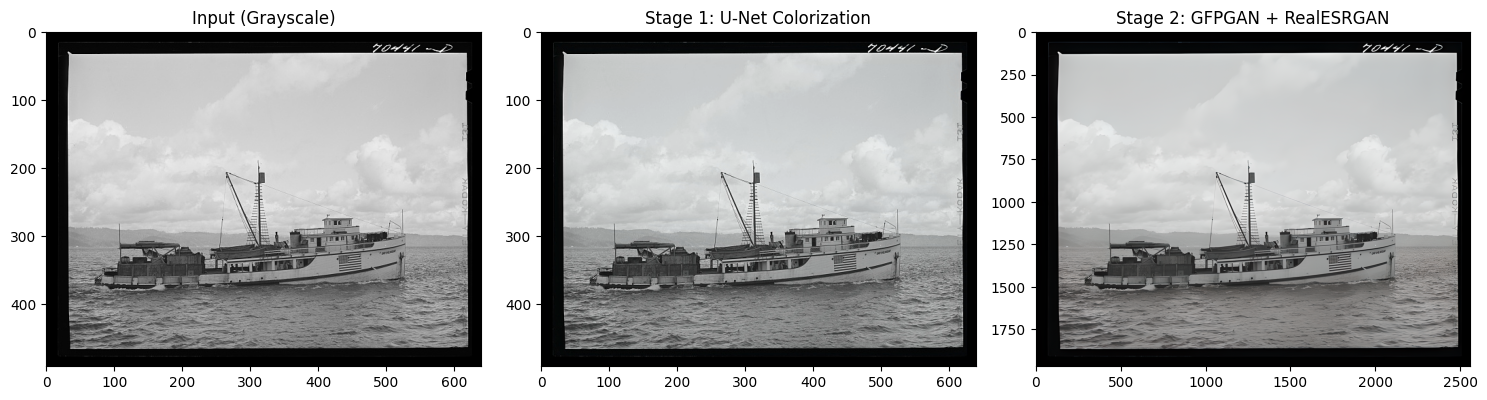

Processing: football_player_1.jpg
Running Stage 1: Colorization...
Running Stage 2: Face Restoration & Upscaling...
	Tile 1/9
	Tile 2/9
	Tile 3/9
	Tile 4/9
	Tile 5/9
	Tile 6/9
	Tile 7/9
	Tile 8/9
	Tile 9/9


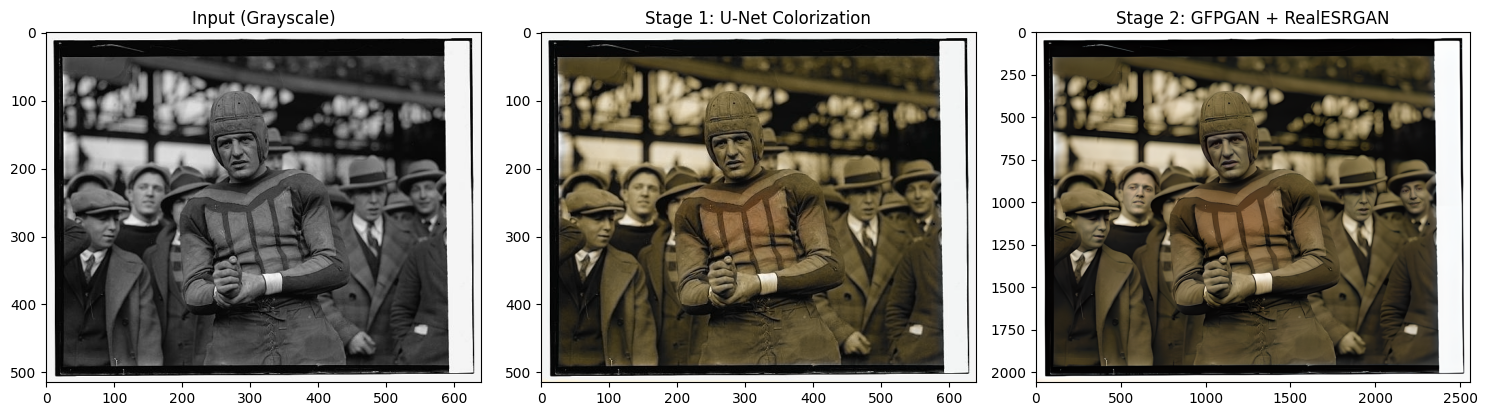

Processing: golf_player.jpg
Running Stage 1: Colorization...
Running Stage 2: Face Restoration & Upscaling...
	Tile 1/9
	Tile 2/9
	Tile 3/9
	Tile 4/9
	Tile 5/9
	Tile 6/9
	Tile 7/9
	Tile 8/9
	Tile 9/9


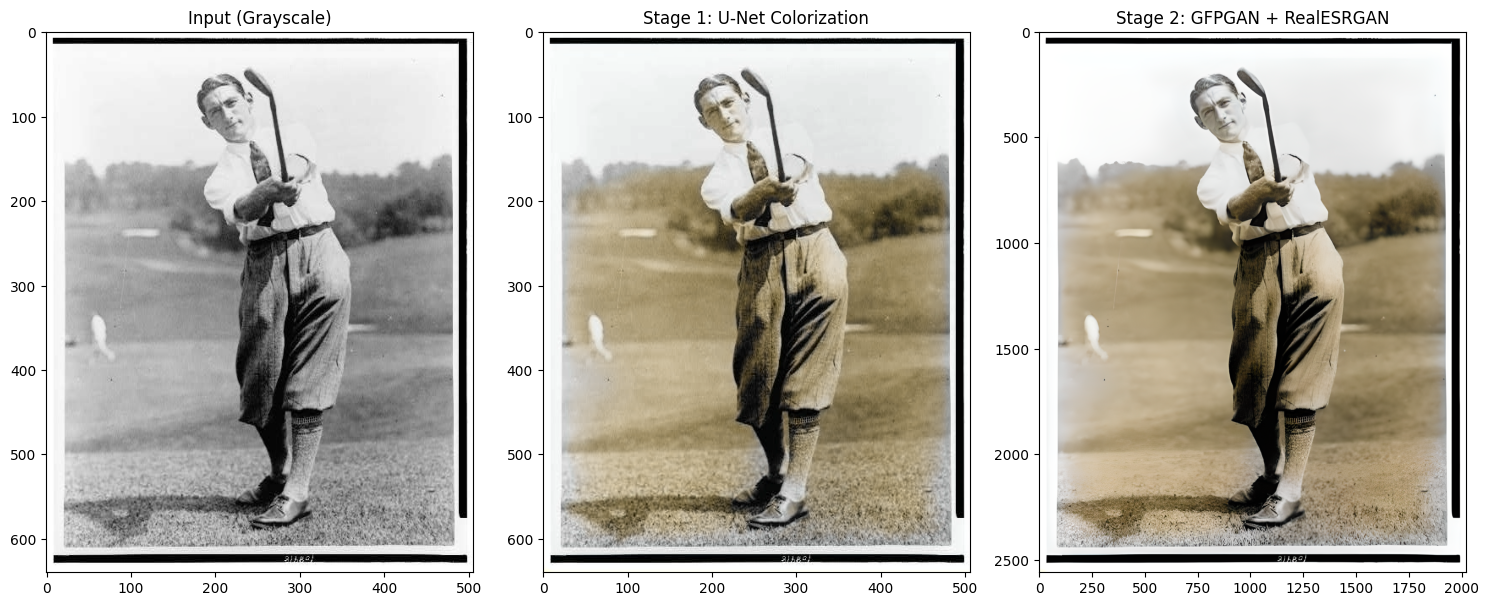

Processing: woman.jpg
Running Stage 1: Colorization...
Running Stage 2: Face Restoration & Upscaling...
	Tile 1/6
	Tile 2/6
	Tile 3/6
	Tile 4/6
	Tile 5/6
	Tile 6/6


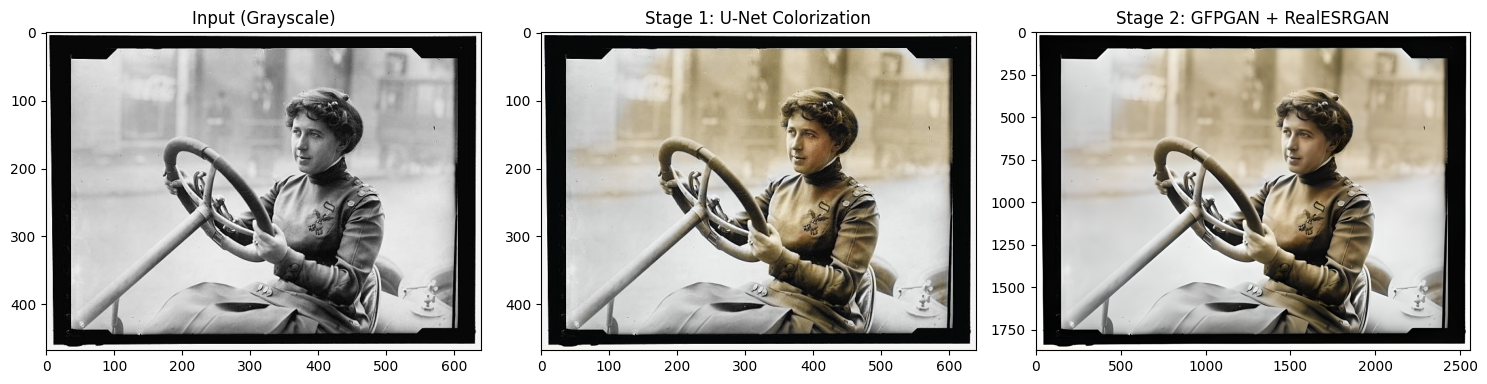

Processing: football_player_2.jpg
Running Stage 1: Colorization...
Running Stage 2: Face Restoration & Upscaling...
	Tile 1/6
	Tile 2/6
	Tile 3/6
	Tile 4/6
	Tile 5/6
	Tile 6/6


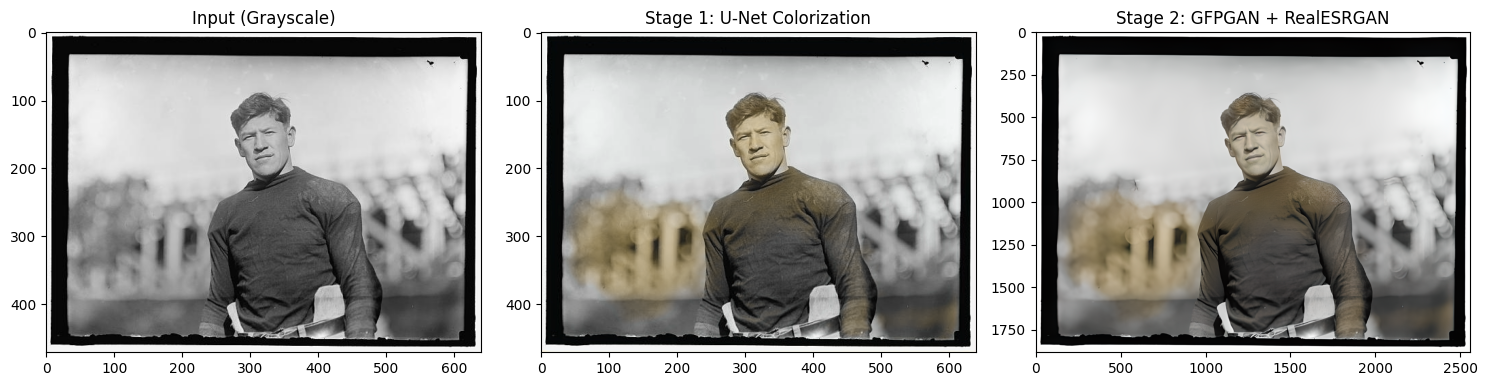

Processing: lincoln.jpg
Running Stage 1: Colorization...
Running Stage 2: Face Restoration & Upscaling...
	Tile 1/9
	Tile 2/9
	Tile 3/9
	Tile 4/9
	Tile 5/9
	Tile 6/9
	Tile 7/9
	Tile 8/9
	Tile 9/9


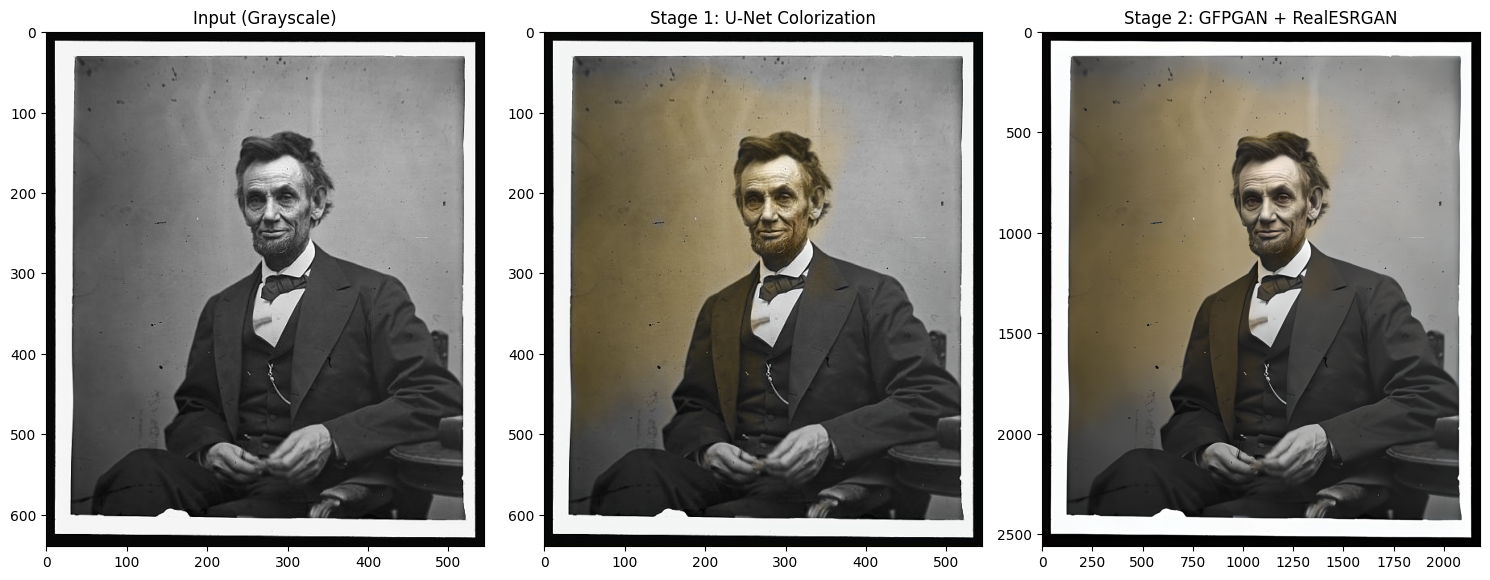

All images have been processed


In [8]:
# Setup paths
COLORIZER_WEIGHTS = "models/main_efficientnet-b2_best.pt"
GFPGAN_WEIGHTS = "models/GFPGANv1.3.pth"
ESRGAN_WEIGHTS = "models/RealESRGAN_x4plus.pth"

inputs_path = "data/test_inputs"
outputs_path = "data/test_outputs"

# Ensure output directory exists
os.makedirs(outputs_path, exist_ok=True)

# Initialize Pipeline
pipeline = ChronoVisionPipeline(COLORIZER_WEIGHTS, GFPGAN_WEIGHTS, ESRGAN_WEIGHTS)

# Get all image files from inputs directory
image_extensions = (".jpg", ".jpeg", ".png")
image_files = [f for f in os.listdir(inputs_path)
                if f.lower().endswith(image_extensions)]

print(f"Found {len(image_files)} images to process")

# Iterate over all images
for image_name in image_files:
    print(f"Processing: {image_name}")

    try:
        # Run pipeline
        original, colorized, restored = pipeline.run(os.path.join(inputs_path, image_name))

        # Get filename without extension
        base_name = os.path.splitext(image_name)[0]

        plt.figure(figsize=(15, 8))

        plt.subplot(1, 3, 1)
        plt.title("Input (Grayscale)")
        plt.imshow(original)

        plt.subplot(1, 3, 2)
        plt.title("Stage 1: U-Net Colorization")
        plt.imshow(colorized)

        plt.subplot(1, 3, 3)
        plt.title("Stage 2: GFPGAN + RealESRGAN")
        plt.imshow(restored)

        plt.tight_layout()
        plt.show()

        # Save outputs
        cv2.imwrite(os.path.join(outputs_path, f"{base_name}_colorized.jpg"),
                    cv2.cvtColor(colorized, cv2.COLOR_RGB2BGR))
        cv2.imwrite(os.path.join(outputs_path, f"{base_name}_restored.jpg"),
                    cv2.cvtColor(restored, cv2.COLOR_RGB2BGR))
    except Exception as e:
        print(f"Error processing {image_name}: {str(e)}")

print("All images have been processed")